# Emotion Model Training

##Load Data
Classes: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
dataset_path = '/content/gdrive/My Drive/Colab Notebooks/EmotionTest/Data/fer2013.csv'
!ls '/content/gdrive/My Drive/Colab Notebooks/EmotionTest/Data'

fer2013.csv


In [0]:
import pandas as pd
import cv2
import numpy as np

image_size=(48,48)

def load_fer2013():
    data = pd.read_csv(dataset_path)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).as_matrix()
    return faces, emotions

In [0]:
# scaling the images between -1 to 1. Images is scaled to [0,1] by dividing it by 255. Further, subtraction by 0.5 and multiplication by 2 changes the range to [-1,1]. 
#[-1,1] has been found a better range for neural network models in computer vision problems.
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [0]:
faces, emotions = load_fer2013()
faces = preprocess_input(faces)

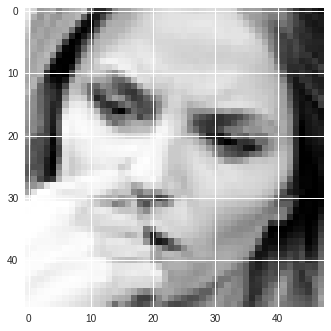

In [0]:
import matplotlib.pyplot as plt

plt.imshow(faces[2].reshape(48,48), cmap='gray')

In [0]:
from sklearn.model_selection import train_test_split

#slpit the data
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

## Training the CNN model

In [0]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2

# parameters
batch_size = 32 # training (35888*0.8/32)=897
num_epochs = 110
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50
base_path = '/content/gdrive/My Drive/Colab Notebooks/EmotionTest/models/'
l2_regularization=0.01

# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
 
# model parameters
regularization = l2(l2_regularization)
 
# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
 
# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]
 
model.fit_generator(data_generator.flow(xtrain, ytrain,batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 46, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 46, 46, 8)    0           batch_normalization_1[0][0]      
_____________________________________

## Prepare de model for web format

In [0]:
model.save('keras.h5')

In [0]:
#we install the tfjs package for conversion
!pip install tensorflowjs 

    100% |████████████████████████████████| 84.7MB 464kB/s 
    100% |████████████████████████████████| 13.9MB 3.9MB/s 
    100% |████████████████████████████████| 61kB 23.0MB/s 
    100% |████████████████████████████████| 358kB 18.8MB/s 
    100% |████████████████████████████████| 3.0MB 12.5MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [0]:
#then we convert the model
#This will create some weight files and the json file which contains the architecture of the model.
!mkdir model2
!tensorflowjs_converter --input_format=keras fmodel.hdf5 model2/

mkdir: cannot create directory ‘model2’: File exists


In [0]:
!ls -la model

total 272
drwxr-xr-x 2 root root   4096 Mar 30 16:04 .
drwxr-xr-x 1 root root   4096 Mar 30 17:18 ..
-rw-r--r-- 1 root root 233692 Mar 30 17:18 group1-shard1of1.bin
-rw-r--r-- 1 root root  31654 Mar 30 17:18 model.json


In [0]:
#zip the model to prepare for downloading it to our local machine
!zip -r model.zip model

updating: model/ (stored 0%)
updating: model/group1-shard1of1.bin (deflated 7%)
updating: model/model.json (deflated 93%)


In [0]:
#finally download the model
from google.colab import files
files.download('model.zip')

## Important links


https://appliedmachinelearning.blog/2018/11/28/demonstration-of-facial-emotion-recognition-on-real-time-video-using-cnn-python-keras/
https://docs.opencv.org/trunk/df/d6c/tutorial_js_face_detection_camera.html

https://github.com/zaidalyafeai/zaidalyafeai.github.io/blob/master/sketcher/main.js
https://github.com/abhijeet3922/FaceEmotion_ID/blob/master/real_time_video.py

https://arxiv.org/pdf/1710.07557.pdf
